<a href="https://colab.research.google.com/github/MashaKubyshina/Learning_to_code/blob/master/Regression_on_%22day%22_bike_sharing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing dataset


**Goal:** find the best predictor for the number of bikes rented (cnt)

Process:
1. Look at the data
2. Plot the data
3. Run linear regression
5. Run one-hot-encoding
6. Scaler min-max
7. Use Forward and Backward selection
8. RidgeCV regression
9. LassoCV regression
10. A few more plots


**Conclusion:** insights and next steps


In [1]:
# We do this to install scikit-learn 0.24 version
# It is a hack for those using colab

!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 165kB/s 


In [2]:
# Check sklearn version

import sklearn

sklearn.__version__

'0.24.2'

In [36]:
# Import necessary libraries to start

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.linear_model as linear_module
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import math
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 

In [4]:
#@title Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

--2021-05-30 01:34:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.04MB/s    in 0.3s    

2021-05-30 01:34:40 (1.04 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]



In [5]:
# unzip

!unzip Bike-Sharing-Dataset.zip

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [ ]:
#@title The description of the data.
!cat Readme.txt

Bike Sharing Dataset

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


Background 

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of tra

In [6]:
# Even though there are 2 datasets in the file, we will be using day.csv for this analysis

df = pd.read_csv('day.csv')
df = df.set_index('instant', drop = True)
df

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341


In [21]:
df.shape

(731, 15)

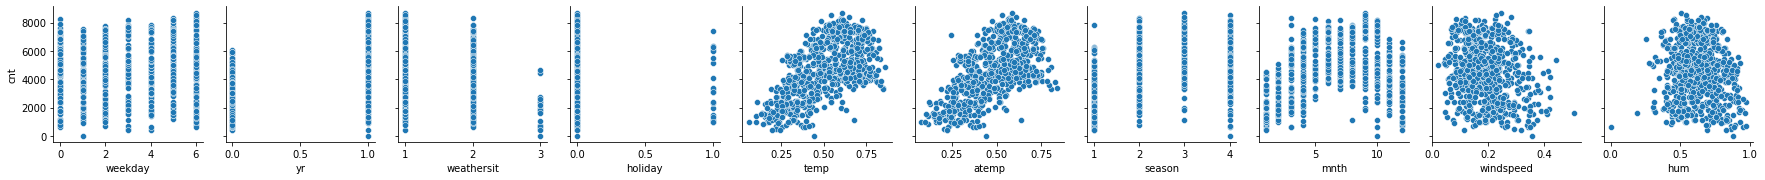

In [22]:
# Before we decide what perdictor to use, we want to check pairplot to see if we find any visual guidance
# It seems like temp and atemp might be the best choices, however mnth and season can offer some insights too

import seaborn as sns

sns.pairplot(df, y_vars="cnt", x_vars=['weekday', 'yr', 'weathersit', 'holiday', 'temp', 'atemp','season','mnth', 'windspeed', 'hum'])

In [27]:
# Regression results summary
# I am using all numeric predictors here

import statsmodels.formula.api as smf
m1 = smf.ols('cnt ~ atemp+windspeed+hum', 
             data=df)
fitted = m1.fit()
print(fitted.summary())

# p < 0,05 means that there is statistical significance

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     209.1
Date:                Sun, 30 May 2021   Prob (F-statistic):           8.99e-98
Time:                        01:49:14   Log-Likelihood:                -6342.3
No. Observations:                 731   AIC:                         1.269e+04
Df Residuals:                     727   BIC:                         1.271e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3773.9591    342.867     11.007      0.0

Text(0.5, 0, 'cnt')

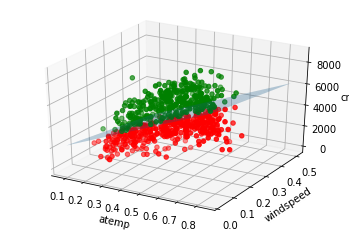

In [37]:
# plotting in 3D atemp, windspeed, cnt

from mpl_toolkits.mplot3d import Axes3D

df.head()

lm = smf.ols(formula='cnt ~ atemp + windspeed', data=df).fit()

lm.params

def f(x, y):
    return lm.params.Intercept + lm.params.atemp * x  + lm.params.windspeed * y

x = df.atemp.sort_values()
y = df.windspeed.sort_values()

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.3)
data_below_serf = df[df['cnt'] < f(df['atemp'], df['windspeed'])]
data_above_serf = df[df['cnt'] >= f(df['atemp'], df['windspeed'])]
ax.scatter(data_below_serf.atemp, data_below_serf.windspeed, data_below_serf.cnt, c='r', marker='o')
ax.scatter(data_above_serf.atemp, data_above_serf.windspeed, data_above_serf.cnt, c='g', marker='o')
ax.set_xlabel('atemp')
ax.set_ylabel('windspeed')
ax.set_zlabel('cnt')

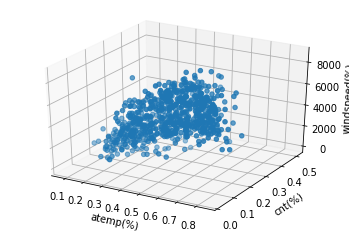

In [35]:
# we can plot a 3D plot showing this data

import matplotlib.pyplot as plt 

data_slice = df[['atemp', 'windspeed', 'cnt']]
data_slice.head()
atemp, cnt, windspeed = [column for column in data_slice.values.T]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=atemp, ys=cnt, zs=windspeed)

ax.set_xlabel('atemp(%)')
ax.set_ylabel('cnt(%)')
ax.set_zlabel('windspeed(%)')

plt.show()

In [29]:
# First we will test linear regression using one variable
# In this analysis I will use atemp as the perdictor

Y = df[['cnt']]
X = df[['atemp']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
# training
import sklearn.linear_model as linear_module
model = linear_module.LinearRegression()
reg = model.fit(X_train, y_train)
print("intercept", reg.intercept_)
print("slope", reg.coef_)

# training error
y_train_predict = reg.predict(X_train)
regression_train_rse = math.sqrt(mean_squared_error(y_train_predict, y_train))
r2_score_tr=r2_score(y_train, y_train_predict)
print("Training error: ", r2_score_tr)

# test error
y_predict = reg.predict(X_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))
r2_score_ts=r2_score(y_test, y_predict)
print("Test error:", r2_score_ts)

# Based on r2_score 46% of variability can be explained by the model

intercept [1045.26868657]
slope [[7352.03536362]]
Training error:  0.36421554476080586
Test error: 0.4681095572313917


In [ ]:
# Out of curiosity I will try using 3 predictors (all of them numerical)

Y = df[['cnt']]
X = df[['atemp','hum', 'windspeed']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

# training
import sklearn.linear_model as linear_module
model = linear_module.LinearRegression()
reg = model.fit(X_train, y_train)
print("intercept", reg.intercept_)
print("slope", reg.coef_)

# training error
y_train_predict = reg.predict(X_train)
regression_train_rse = math.sqrt(mean_squared_error(y_train_predict, y_train))
r2_score_tr=r2_score(y_train, y_train_predict)
print("Training error: ", r2_score_tr)

# test error
y_predict = reg.predict(X_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))
r2_score_ts=r2_score(y_test, y_predict)
print("Test error:", r2_score_ts)

# Agian, based on r2_score, only 46% of variability can be explained by the model
# Using 3 predictors doesn't improve the results (actually the result is slightly worse)

intercept [4305.15029406]
slope [[ 7337.24085665 -3687.06936096 -4780.30933564]]
Training error:  0.45088999839945454
Test error: 0.46712556723261367


In [ ]:
# Standardizing atemp and hum
# Ideally we would like to standardize values that are far apart on the numeric scale

Y = df[['cnt']]
X = df[['atemp', 'hum']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

# training
import sklearn.linear_model as linear_module
model = linear_module.LinearRegression()
reg = model.fit(X_train, y_train)
print("intercept", reg.intercept_)
print("slope", reg.coef_)

intercept [2823.51110479]
slope [[ 7692.5174507  -3054.61384174]]


In [ ]:
scaler = preprocessing.StandardScaler().fit(X)

scaler

StandardScaler()

In [ ]:
print(scaler.mean_, scaler.scale_)

[0.47435399 0.62789406] [0.16284968 0.14233164]


In [ ]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled[0:5]

array([[ 0.31647598, -0.10230377],
       [ 0.84756086,  0.71445068],
       [ 0.7622552 , -1.66847695],
       [ 0.82051752,  0.44219919],
       [ 0.09682556,  0.80901854]])

In [ ]:
X_train[0:5]

,atemp,hum
instant,,
522,0.525892,0.613333
148,0.612379,0.729583
473,0.598487,0.390417
636,0.607975,0.690833
332,0.490122,0.743043


In [ ]:
# training

model = linear_module.LinearRegression()
reg = model.fit(X_train_scaled, y_train)
print("intercept", reg.intercept_)
print("slope", reg.coef_)

intercept [4554.51354449]
slope [[1252.72397205 -434.76820095]]


In [ ]:
# test error

X_test_scaled = scaler.transform(X_test)


y_predict = reg.predict(X_test_scaled)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.45859155263197837

In [ ]:
# min-max scaler

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_train_minmax[0:5]

array([[0.61612201, 0.54221924],
       [0.73537866, 0.69038712],
       [0.71622302, 0.25809889],
       [0.729306  , 0.64099783],
       [0.56679887, 0.70754273]])

In [ ]:
X_train[0:5]

,atemp,hum
instant,,
522,0.525892,0.613333
148,0.612379,0.729583
473,0.598487,0.390417
636,0.607975,0.690833
332,0.490122,0.743043


In [ ]:
# The predictors I am interested in are "season" and "mnth" (month)
# Both of these predictors are categorical (not numeric)
# I will use one hot encoding to convert them to binary and see if one of them improves the performace of the model

# I will start with working on season
# I will first do everything step by step and then do it in one piece of code for mnth

df.season.unique()

array([1, 2, 3, 4])

In [ ]:
s_list=list(df.season.unique())
s_list

[1, 2, 3, 4]

In [ ]:
# I want to make sure the enc works

enc = preprocessing.OneHotEncoder(categories=[s_list])
enc

OneHotEncoder(categories=[[1, 2, 3, 4]])

In [ ]:
x = [[1], [3]]
enc.fit(x)
enc.transform(df.season.values.reshape(-1,1))

<731x4 sparse matrix of type '<class 'numpy.float64'>'
	with 731 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame.sparse.from_spmatrix(enc.transform(df.season.values.reshape(-1,1)))

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
726,1.0,0.0,0.0,0.0
727,1.0,0.0,0.0,0.0
728,1.0,0.0,0.0,0.0
729,1.0,0.0,0.0,0.0


In [ ]:
X_enc = enc.transform(df.season.values.reshape(-1,1))

X_enc_train, X_enc_test, y_train, y_test = train_test_split(X_enc, Y, test_size=0.25, random_state=1)

# training

model = linear_module.LinearRegression()
reg = model.fit(X_enc_train, y_train)
print("intercept", reg.intercept_)
print("slope", reg.coef_)

intercept [4519.08411248]
slope [[-1917.99936672   538.60081903  1144.40913076   234.98941693]]


In [ ]:
y_predict = reg.predict(X_enc_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

r2_score(y_test, y_predict)

# 34% of variability can be explained by the model
# This result is worse then using atemp

0.34748148187140815

In [ ]:
# one hot encoding for month variable (mnth)

df.mnth.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
m_list=list(df.mnth.unique())
m_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
enc = preprocessing.OneHotEncoder(categories=[m_list])
enc

OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])

In [ ]:
x = [[1], [3]]
enc.fit(x)
enc.transform(df.mnth.values.reshape(-1,1))

<731x12 sparse matrix of type '<class 'numpy.float64'>'
	with 731 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame.sparse.from_spmatrix(enc.transform(df.mnth.values.reshape(-1,1)))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# I will use linear regression in one piece of code here

Y = df[['cnt']]
X = enc.transform(df.mnth.values.reshape(-1,1))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

# training
import sklearn.linear_model as linear_module
model = linear_module.LinearRegression()
reg = model.fit(X_train, y_train)
print("intercept", reg.intercept_)
print("slope", reg.coef_)

# training error
y_train_predict = reg.predict(X_train)
regression_train_rse = math.sqrt(mean_squared_error(y_train_predict, y_train))
r2_score_tr_cyl=r2_score(y_train, y_train_predict)
print("Training error: ", r2_score_tr_cyl)

# test error
y_predict = reg.predict(X_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))
r2_score_ts_cyl=r2_score(y_test, y_predict)
print("Test error:", r2_score_ts_cyl)

# 41% of variability can be explained by the model (better than season, still worse than atemp)

intercept [4528.47326579]
slope [[-2311.5187204  -1911.74353606  -600.96044523   137.40428501
    756.20020336  1135.50499391  1035.46151752  1160.60836662
   1308.47013042   608.23506896  -329.98347008  -987.67839404]]
Training error:  0.36884629524644696
Test error: 0.4159060202103074


In [ ]:
df['b_mnth']=enc.transform(df.mnth.values.reshape(-1,1))
df['b_mnth']

instant
1        (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
2        (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
3        (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
4        (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
5        (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
                             ...                        
727      (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
728      (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
729      (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
730      (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
731      (0, 0)\t1.0\n  (1, 0)\t1.0\n  (2, 0)\t1.0\n ...
Name: b_mnth, Length: 731, dtype: object

In [ ]:
df

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,b_mnth
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.24.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, joblib, scipy, threadpoolctl
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn


In [ ]:
sklearn.show_versions()


System:
    python: 3.7.10 (default, May  3 2021, 02:48:31)  [GCC 7.5.0]
executable: /usr/bin/python3
   machine: Linux-5.4.109+-x86_64-with-Ubuntu-18.04-bionic

Python dependencies:
          pip: 19.3.1
   setuptools: 56.1.0
      sklearn: 0.24.2
        numpy: 1.19.5
        scipy: 1.4.1
       Cython: 0.29.23
       pandas: 1.1.5
   matplotlib: 3.2.2
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True


In [ ]:
# We will use min_max_scaler

Y = df[['cnt']]
X_unscaled = df[['atemp','windspeed', 'hum', 'weekday', 'holiday']]

X = min_max_scaler.fit_transform(X_unscaled)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [ ]:
# Forward and backward selection using regression model

from sklearn.feature_selection import SequentialFeatureSelector
from time import time
from sklearn.linear_model import Lasso

model = linear_module.LinearRegression()
reg = model.fit(X_train, y_train)

# this feature is optional: n_features_to_select=4, we are telling how many features to select

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(reg, n_features_to_select=4,
                                        direction='forward').fit(X_train, y_train)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(reg,
                                       direction='backward').fit(X_train, y_train)
toc_bwd = time()

sfs_forward.get_support()
toc_fwd = time()
print(toc_fwd)
print(tic_bwd)

1622241005.8455493
1622241005.7625327


In [ ]:
X_unscaled.columns[sfs_forward.get_support()]

Index(['atemp', 'windspeed', 'hum', 'weekday'], dtype='object')

In [ ]:
X_unscaled.columns[sfs_backward.get_support()]

Index(['atemp', 'hum'], dtype='object')

In [ ]:
sfs_forward.get_params()

{'cv': 5,
 'direction': 'forward',
 'estimator': LinearRegression(),
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__normalize': False,
 'estimator__positive': False,
 'n_features_to_select': 4,
 'n_jobs': None,
 'scoring': None}

In [ ]:
X_train[0:5]

array([[0.58651472, 0.38588822, 0.63067661, 0.33333333, 0.        ],
       [0.70004059, 0.42818509, 0.75021388, 1.        , 0.        ],
       [0.68180546, 0.51793891, 0.40145707, 0.33333333, 0.        ],
       [0.69425974, 0.23079143, 0.71036812, 0.66666667, 0.        ],
       [0.53956177, 0.24683031, 0.7640545 , 0.16666667, 0.        ]])

In [ ]:
y_predict = sfs_backward.estimator.predict(X_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

# Using backward selection based on r2_score, 46% of variability can be explained by the model

0.4669865012454463

In [ ]:
df.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'b_mnth'],
      dtype='object')

In [ ]:
# We will now use ridge model (all predictors)

from sklearn.linear_model import Ridge

Y = df[['cnt']]
X = df[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)


regressor = Ridge(alpha=0.5)
regressor.fit(X_train,y_train)
y_predict = regressor.predict(X_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

r2_score(y_test, y_predict)


# using ridge with all variables we get r2_score: 100% of variability can be explained by the model
# We obtain this result because we are using 'casual' and 'registered' as predictors which are 2 parts of cnt
# I run this code just to show what happens when we use these two variables

1.0

In [ ]:
# Ridge (without 'casual', 'registered')

from sklearn.linear_model import Ridge

Y = df[['cnt']]
X = df[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)


regressor = Ridge(alpha=0.5)
regressor.fit(X_train,y_train)
y_predict = regressor.predict(X_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

r2_score(y_test, y_predict)

# using ridge without 'casual' and 'registered, we get r2_score of 0.81; 81% of variability can be explained by the model

0.8151866615686227

In [ ]:
reg.intercept_

array([4566.34888091])

In [ ]:
reg.coef_

array([[ 5603.85575721, -2316.80432914, -3574.04609592,   426.71408734,
         -397.44893839]])

In [ ]:
# ridge cross validation

from sklearn.linear_model import RidgeCV

Y = df[['cnt']]
X = df[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)


ridge_regressor = RidgeCV(cv=5, alphas = [0.01,0.1, 0.5])
ridge_regressor.fit(X_train,y_train)
y_predict = ridge_regressor.predict(X_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

r2_score(y_test, y_predict)

# using ridge cross-validation we get r2_score of 0.81; 81% of variability can be explained by the model

0.8151866615686227

In [ ]:
ridge_regressor.coef_

array([[  471.94527848,  2056.41109398,   -25.28919054,  -418.25579897,
           77.12693269,    99.02542242,  -613.74204059,  2550.05455666,
         2892.81743602, -1163.21588071, -2250.6625475 ]])

In [ ]:
ridge_regressor.alpha_

0.5

In [ ]:
# Lasso cross validation model

from sklearn.linear_model import LassoCV
lasso_regressor = LassoCV(alphas=[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 50, 100, 1000 ])
lasso_regressor.fit(X_train,y_train)
y_predict = lasso_regressor.predict(X_test)
regression_model_mse = mean_squared_error(y_predict, y_test)
regression_test_rse = math.sqrt(mean_squared_error(y_predict, y_test))

r2_score(y_test, y_predict)

# using lasso cross-validation we get r2_score of 0.81; 81% of variability can be explained by the model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405946.8502123356, tolerance: 161151.3585671982
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411113.29329031706, tolerance: 161151.3585671982
  tol, rng, random, positive)


0.8144558336430714

In [ ]:
lasso_regressor.alpha_

0.75

In [ ]:
lasso_regressor.coef_

array([  462.34200783,  2056.06002391,   -24.12567135,  -396.91822873,
          77.59214947,    97.02250248,  -587.4725729 ,  1771.97707543,
        3861.33822845, -1284.59737661, -2473.08476985])

In [ ]:
# As the last step I want to check the dataset again and run some plots to visualize the data

df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


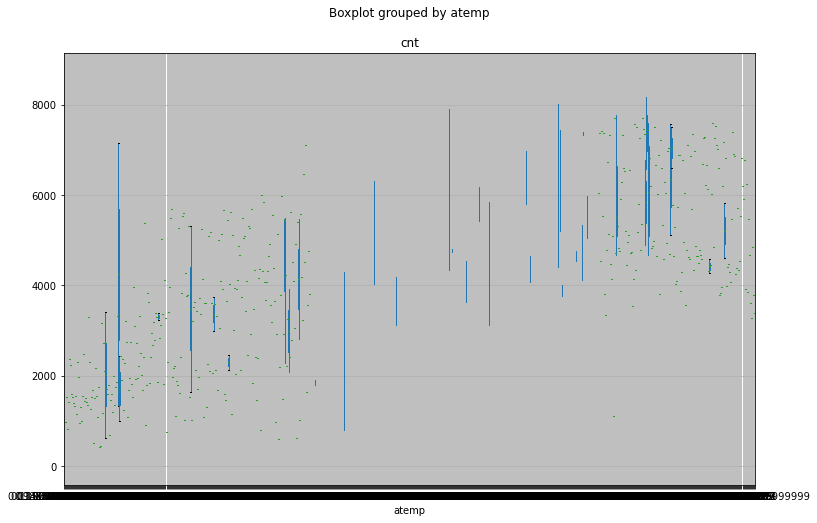

In [ ]:
# In this case I am doing exploratory analysis at the very end (to see if the predictors I get make sense)

df.boxplot('cnt', by='atemp', figsize=(12,8), grid=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


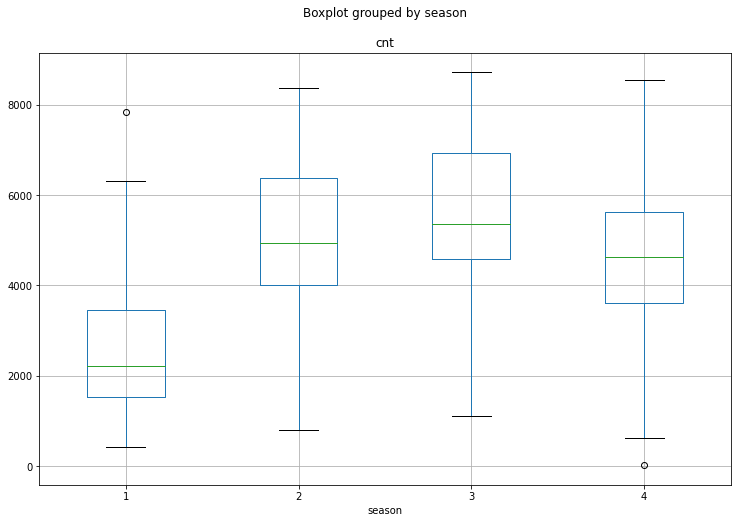

In [ ]:
df.boxplot('cnt', by='season', figsize=(12,8), grid=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


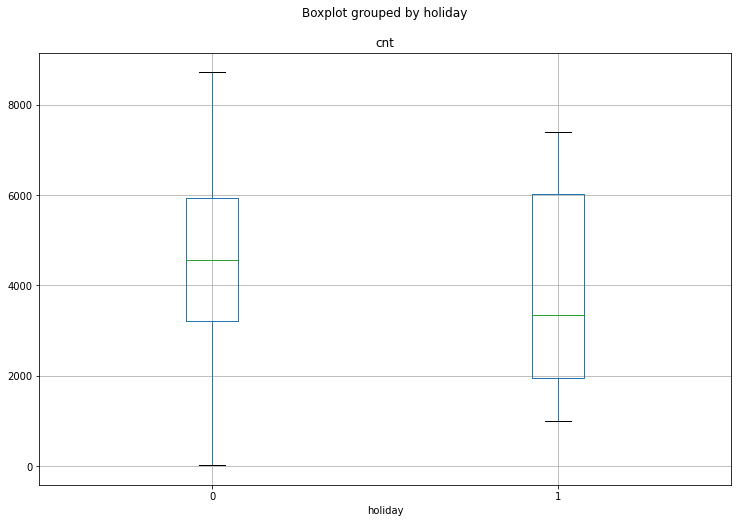

In [ ]:
df.boxplot('cnt', by='holiday', figsize=(12,8), grid=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


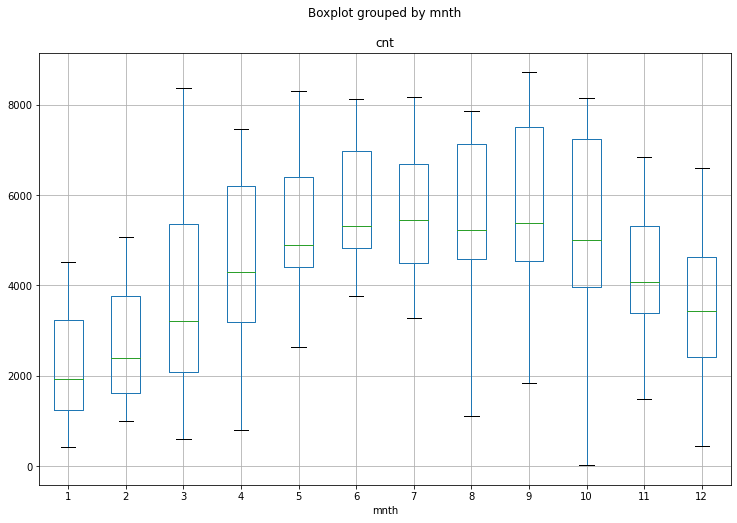

In [ ]:
df.boxplot('cnt', by='mnth', figsize=(12,8), grid=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


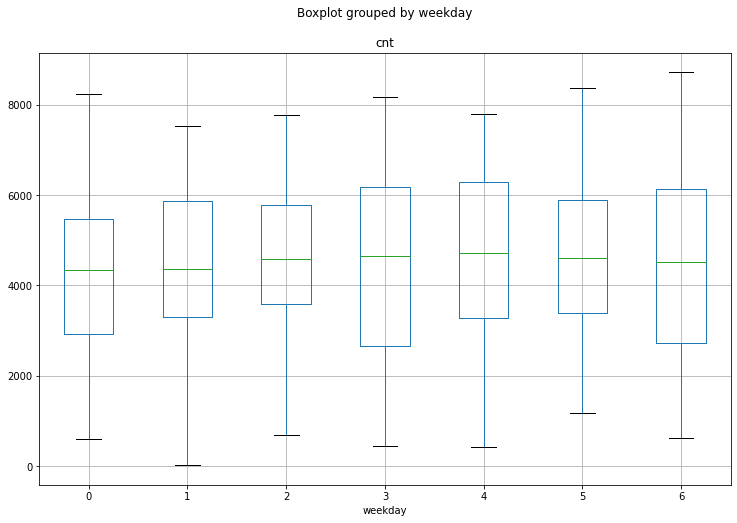

In [ ]:
df.boxplot('cnt', by='weekday', figsize=(12,8), grid=True)

**Conclusion**

It is interesting to note that on the plot season looks like a good predictor, however it is not so when we run it through regression model. 

Atemp seems to be the best predictor using linear regression 
Using Ridge and Lasso gives us good results as well.

I would also approach this dataset from real-life perspective. What can be a good predictor is not only what provides a good score, but also that is feasable and predicts ahead of time (not too broad, not too narrow).

For example, season might be a good predictor, however it is very broad and the bike renting business might want to narrow down to how many bikes they need in this location every week of that season. 
Hour can be too narrow, it is probably impossible to vary the supplies of bikes by hour. Thus even if the predictability is high, it could have little usefulness in real life. 
Month could be another good predictor.
If I put myself in the shoes of the planner for bike renting, the information that would be useful to me is how many bikes more (by what factor) are rented in weekends and holidays vs. weekdays. How bike rentals change each month. These are easy to plan for.
Also, I would want to know what is the hourly change of the demand on weekdays and on week-ends.
Looking at data I would use atemp or temp as the predictor for bike demand.

**Data Insights:** 

-mnth is interesting to look at from business perspective (we know what month is coming; also atemp and month are related)
-mnth, one hot encoding, linear reg: 41% of variability can be explained by the model
-atemp, linear reg: 46% of variability can be explained by the model
-using ridge and lasso we get r2_score of 81%, which means that 81% of variability can be explained by the model
